In [25]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import seaborn as sns
import random as rd # generating random numbers

# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


# settings
import warnings
warnings.filterwarnings("ignore")

from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

In this competition, you will predict sales for the thousands of product families sold at Favorita stores located in Ecuador. The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers. Additional files include supplementary information that may be useful in building your models.

### File Descriptions and Data Field Information

### train.csv
The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.

##### store_nbr
identifies the store at which the products are sold.

##### family 
identifies the type of product sold.

##### sales 
gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).

##### onpromotion
gives the total number of items in a product family that were being promoted at a store at a given date.

### test.csv
The test data, having the same features as the training data. You will predict the target sales for the dates in this file.
The dates in the test data are for the 15 days after the last date in the training data.

### sample_submission.csv
A sample submission file in the correct format.

### stores.csv
Store metadata, including city, state, type, and cluster.
cluster is a grouping of similar stores.

### oil.csv
Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

### holidays_events.csv
Holidays and Events, with metadata
NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

### Additional Notes
Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.
https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data


In [2]:
holidays_events = pd.read_csv("holidays_events.csv")
oil = pd.read_csv("oil.csv")
sample = pd.read_csv("sample_submission.csv")
stores = pd.read_csv("stores.csv")
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")
transactions = pd.read_csv("transactions.csv")

# VISUALISATION

#### HOLIDAYS

In [3]:
holidays_events

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [10]:
holidays_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [18]:
holidays_events.describe()

,date,type,locale,locale_name,description,transferred
count,350,350,350,350,350,350
unique,312,6,3,24,103,2
top,2014-06-25,Holiday,National,Ecuador,Carnaval,False
freq,4,221,174,174,10,338


<AxesSubplot:>

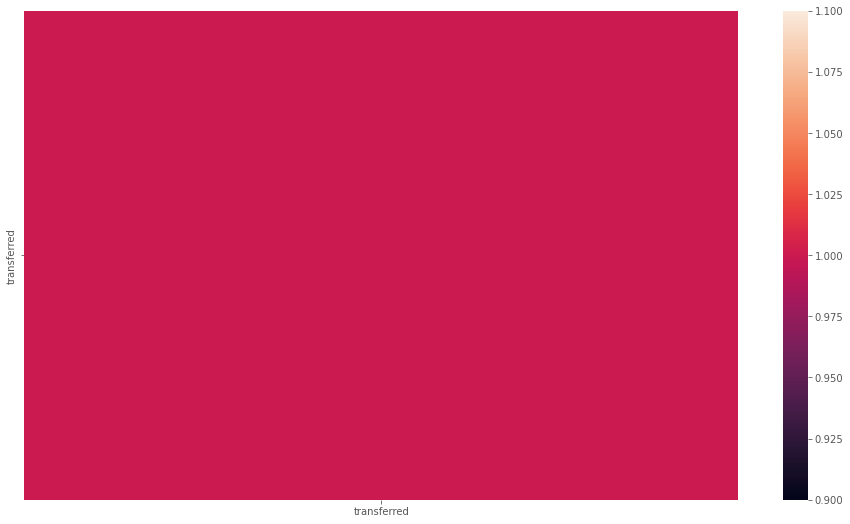

In [33]:
sns.heatmap(holidays_events.corr())

#### oil

In [4]:
oil

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


In [11]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [19]:
oil.describe()

,dcoilwtico
count,1175.000000
mean,67.714366
std,25.630476
min,26.190000
25%,46.405000
50%,53.190000
75%,95.660000
max,110.620000


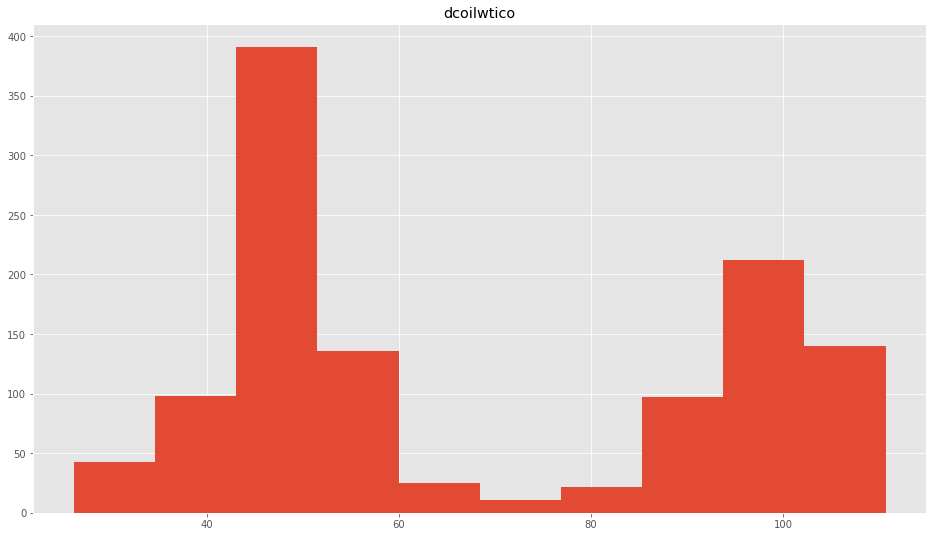

In [27]:
oil.hist()
plt.show()

<AxesSubplot:>

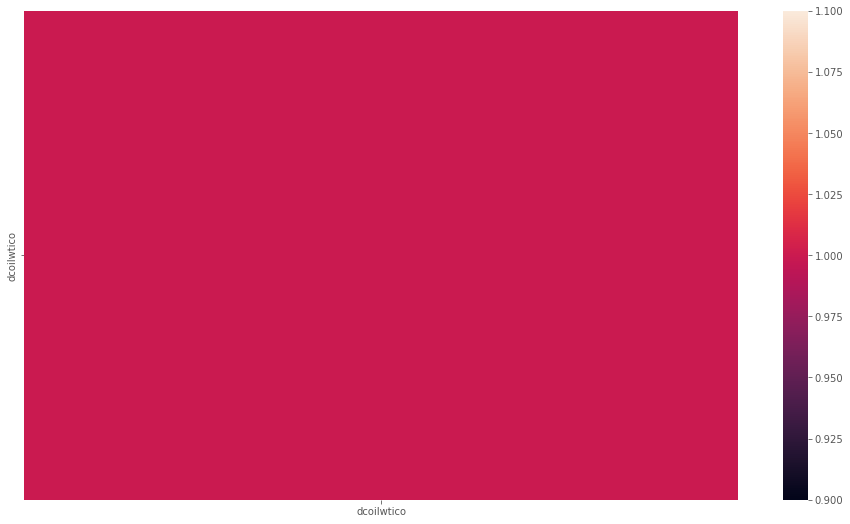

In [34]:
sns.heatmap(oil.corr())

#### sample

In [5]:
sample

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0
...,...,...
28507,3029395,0.0
28508,3029396,0.0
28509,3029397,0.0
28510,3029398,0.0


In [12]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      28512 non-null  int64  
 1   sales   28512 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 445.6 KB


In [20]:
sample.describe()

,id,sales
count,2.851200e+04,28512.0
mean,3.015144e+06,0.0
std,8.230850e+03,0.0
min,3.000888e+06,0.0
25%,3.008016e+06,0.0
50%,3.015144e+06,0.0
75%,3.022271e+06,0.0
max,3.029399e+06,0.0


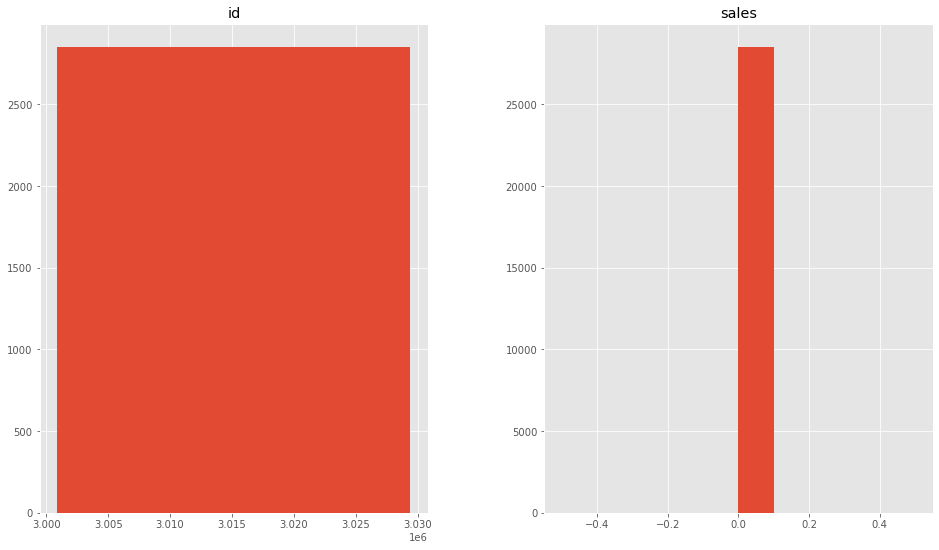

In [28]:
sample.hist()
plt.show()

<AxesSubplot:>

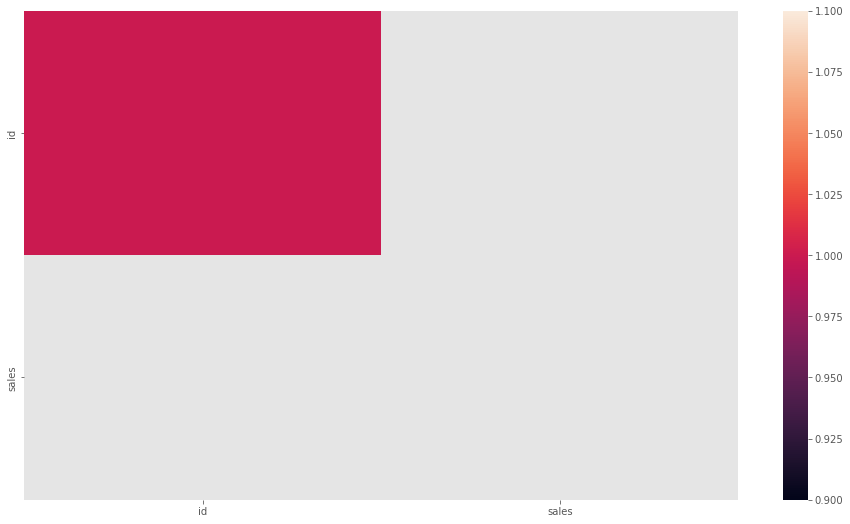

In [35]:
sns.heatmap(sample.corr())

#### stores

In [6]:
stores

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15


In [13]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [21]:
stores.describe()

,store_nbr,cluster
count,54.000000,54.000000
mean,27.500000,8.481481
std,15.732133,4.693395
min,1.000000,1.000000
25%,14.250000,4.000000
50%,27.500000,8.500000
75%,40.750000,13.000000
max,54.000000,17.000000


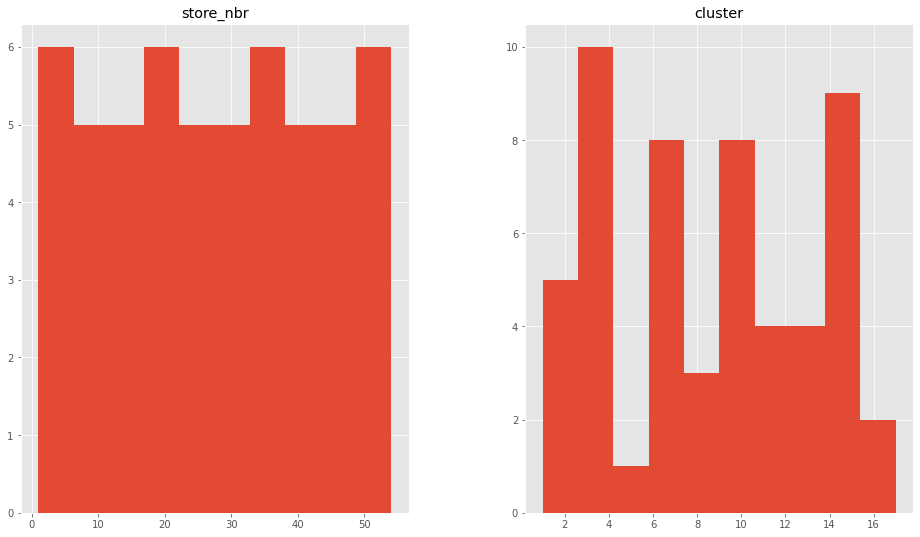

In [29]:
stores.hist()
plt.show()

<AxesSubplot:>

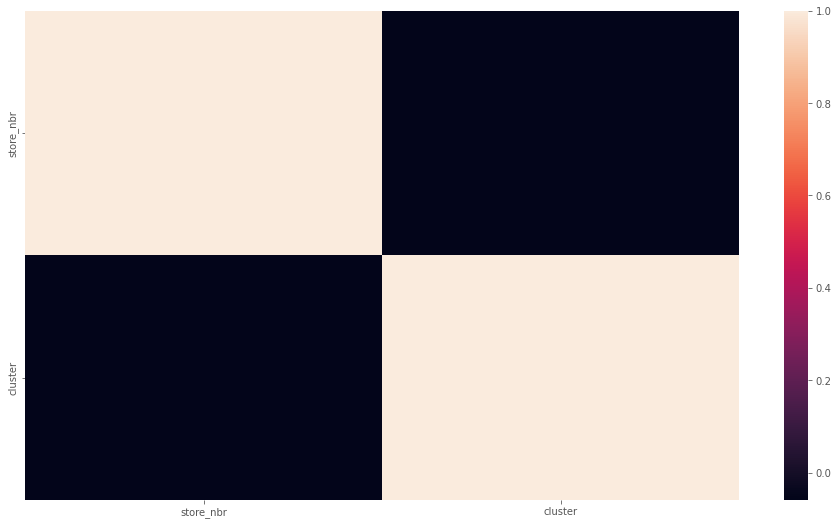

In [36]:
sns.heatmap(stores.corr())

#### test

In [7]:
test

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


In [14]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


In [22]:
test.describe()

,id,store_nbr,onpromotion
count,2.851200e+04,28512.000000,28512.000000
mean,3.015144e+06,27.500000,6.965383
std,8.230850e+03,15.586057,20.683952
min,3.000888e+06,1.000000,0.000000
25%,3.008016e+06,14.000000,0.000000
50%,3.015144e+06,27.500000,0.000000
75%,3.022271e+06,41.000000,6.000000
max,3.029399e+06,54.000000,646.000000


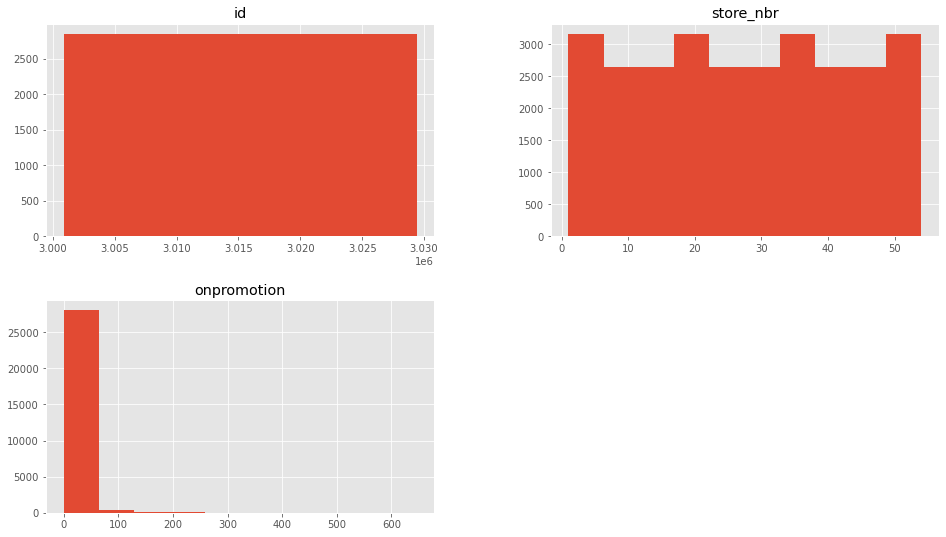

In [30]:
test.hist()
plt.show()

<AxesSubplot:>

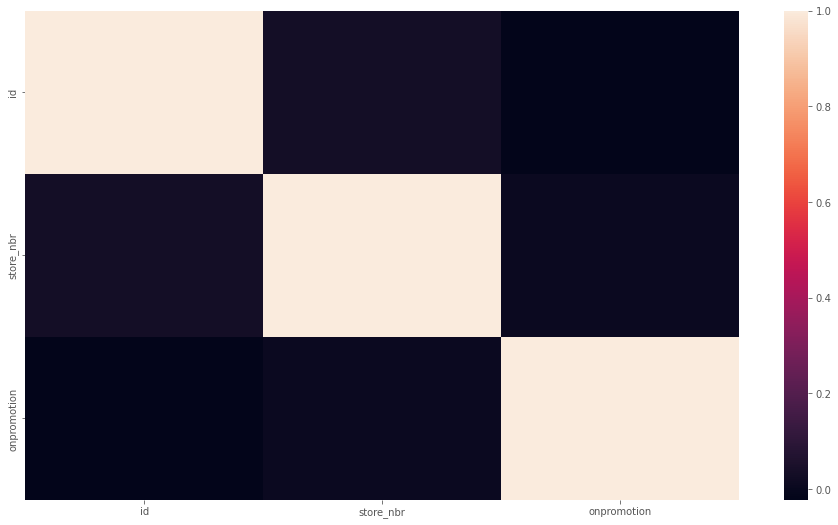

In [37]:
sns.heatmap(test.corr())

#### train

In [8]:
train

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [23]:
train.describe()

,id,store_nbr,sales,onpromotion
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2.750000e+01,3.577757e+02,2.602770e+00
std,8.662819e+05,1.558579e+01,1.101998e+03,1.221888e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02


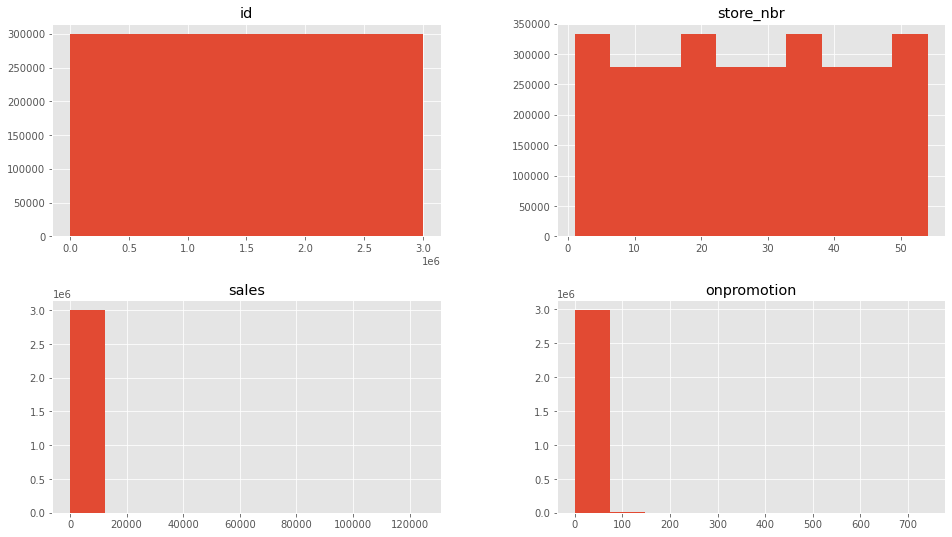

In [31]:
train.hist()
plt.show()

<AxesSubplot:>

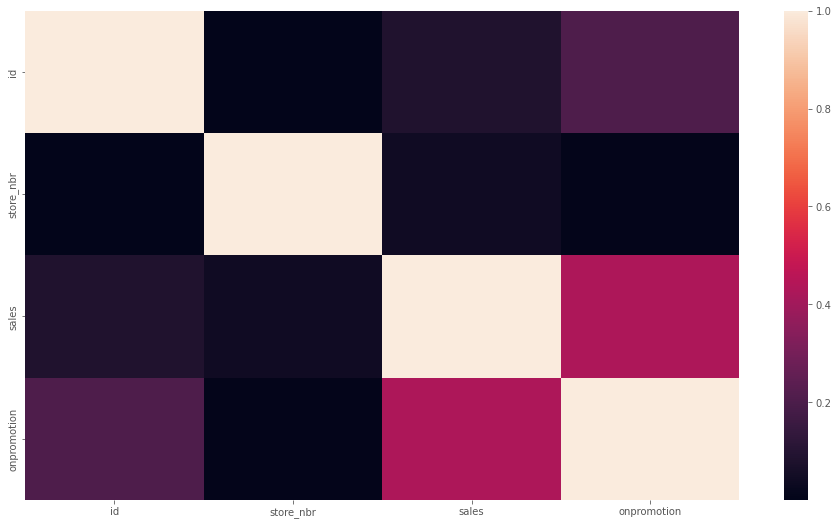

In [38]:
sns.heatmap(train.corr())

#### transactions

In [9]:
transactions

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


In [16]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


In [24]:
transactions.describe()

,store_nbr,transactions
count,83488.000000,83488.000000
mean,26.939237,1694.602158
std,15.608204,963.286644
min,1.000000,5.000000
25%,13.000000,1046.000000
50%,27.000000,1393.000000
75%,40.000000,2079.000000
max,54.000000,8359.000000


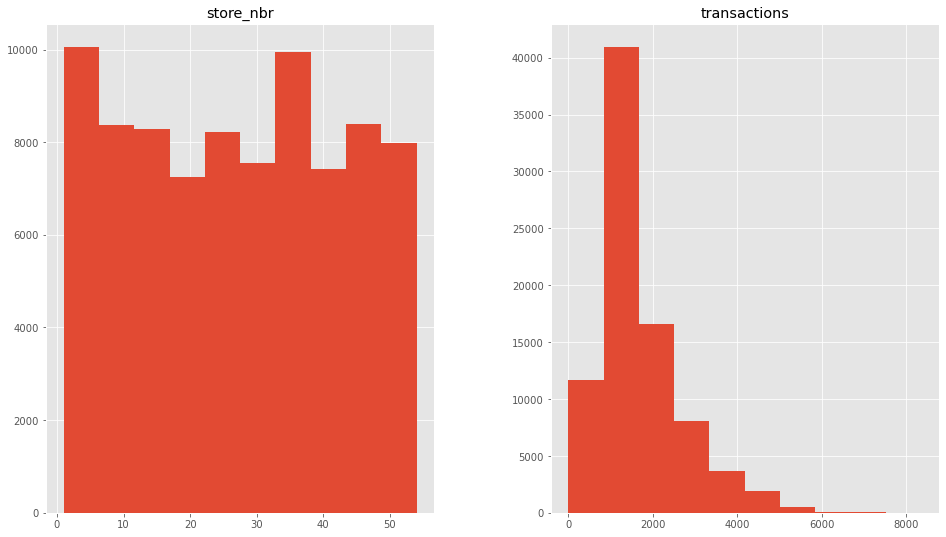

In [32]:
transactions.hist()
plt.show()

<AxesSubplot:>

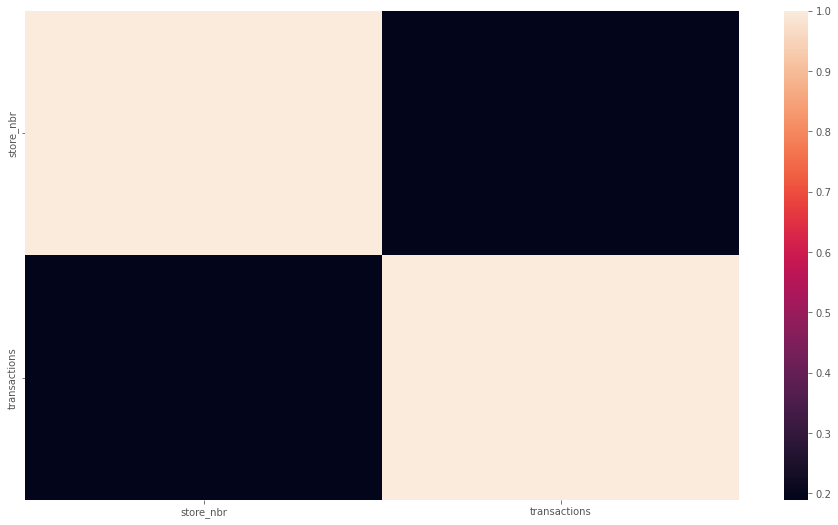

In [39]:
sns.heatmap(transactions.corr())

## ANALISIS DE DATOS PROFUNDO

Lo que nos interesa es encontrar la mejor epoca para detectar ventas y ver los productos mejor vendidos asi como detectar cuando poner ofertas. 

Vamos a determinar cual es el periodo de tiempo en el que analisaremos nuestros datos

In [54]:
#DATE

<AxesSubplot:xlabel='date'>

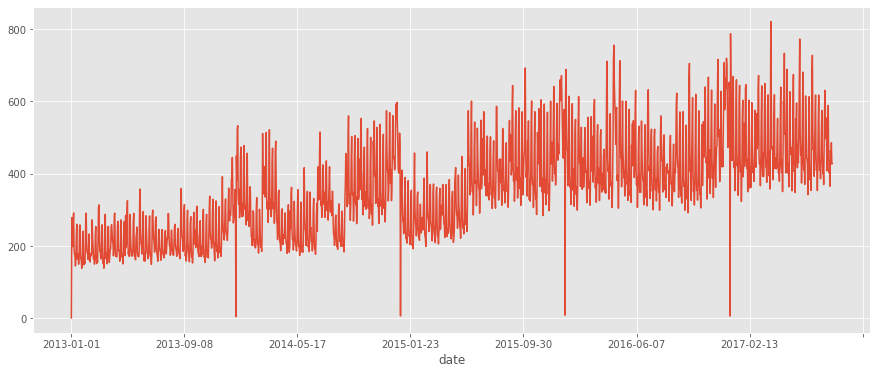

In [53]:
fig = plt.figure(figsize=(15,6))
train.groupby(by='date')['sales'].mean().plot()

In [49]:
test['date']

0        2017-08-16
1        2017-08-16
2        2017-08-16
3        2017-08-16
4        2017-08-16
            ...    
28507    2017-08-31
28508    2017-08-31
28509    2017-08-31
28510    2017-08-31
28511    2017-08-31
Name: date, Length: 28512, dtype: object

In [50]:
train['date']

0          2013-01-01
1          2013-01-01
2          2013-01-01
3          2013-01-01
4          2013-01-01
              ...    
3000883    2017-08-15
3000884    2017-08-15
3000885    2017-08-15
3000886    2017-08-15
3000887    2017-08-15
Name: date, Length: 3000888, dtype: object

In [55]:
#TIENDAS

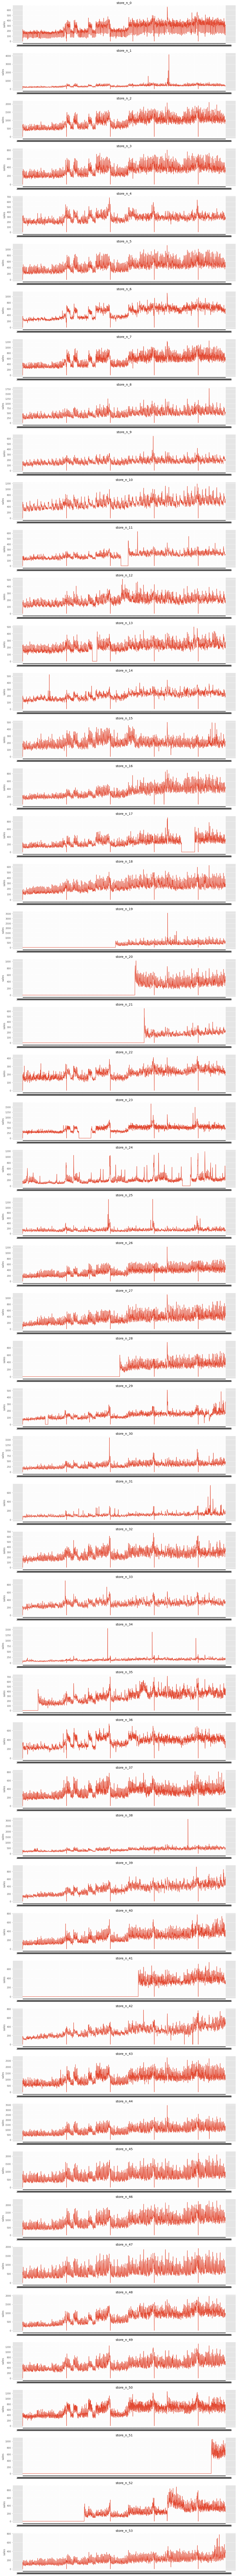

In [56]:
fig, axes = plt.subplots(54, 1, figsize=(15, 54*3))

for ax, i in zip(axes.flat, np.arange(0,54,1)):
    sns.lineplot(ax=axes[i], x=train[train.store_nbr==(i+1)].groupby(by='date')['sales'].mean().reset_index().date.values, y=train[train.store_nbr==(i+1)].groupby(by='date')['sales'].mean())
    ax.set_title(f'store_n_{i}') 
    
fig.tight_layout()

In [57]:
stores.groupby(by=['city']).store_nbr.nunique().sort_values(ascending=False)

city
Quito            18
Guayaquil         8
Santo Domingo     3
Cuenca            3
Manta             2
Machala           2
Latacunga         2
Ambato            2
Guaranda          1
Ibarra            1
Esmeraldas        1
Babahoyo          1
Loja              1
El Carmen         1
Daule             1
Playas            1
Puyo              1
Quevedo           1
Cayambe           1
Riobamba          1
Salinas           1
Libertad          1
Name: store_nbr, dtype: int64

In [58]:
## Día Festivo

In [59]:
holidays_events.query("type=='Event'").description.value_counts()

Dia de la Madre                                    5
Mundial de futbol Brasil: Octavos de Final         4
Black Friday                                       3
Cyber Monday                                       3
Mundial de futbol Brasil: Cuartos de Final         2
Mundial de futbol Brasil: Semifinales              2
Terremoto Manabi+21                                1
Terremoto Manabi+14                                1
Terremoto Manabi+15                                1
Terremoto Manabi+16                                1
Terremoto Manabi+17                                1
Terremoto Manabi+18                                1
Terremoto Manabi+19                                1
Terremoto Manabi+20                                1
Terremoto Manabi+24                                1
Terremoto Manabi+22                                1
Terremoto Manabi+23                                1
Terremoto Manabi+12                                1
Terremoto Manabi+25                           

# DATA CLEANING


In [ ]:
stores.groupby(by=['city']).store_nbr.nunique().sort_values(ascending=False)


# STATISTIC ANALYSIS

# FEATURE ENGINEERING

# PRE - MODELING WORK

# MODELING

# RESULTS